# Affordable Transit

## Overview

Public spending on transit increases community affordability by reducing overall household transportation costs as households reduce car utilization. In this "notebook" we highlight this pattern by examining data compiled by the Center for Neighborhood Technology as part of their Housing and Transportation Affordability Index.

## Setting up our notebook

Before we get to doing any actual work with data, we have to import the packaged libraries of code that we will use to conduct our analysis. Using already-existing libraries dramatically cuts down on the amount of code one has to write.

The Python packages we are using are popular and well-documented; they will allows us to efficiently read, organize, and manipulate CSV data, as well as run statistical functions and visualize results.

We also configure our plotting library to ensure user-friendly visualizations.

In [1]:
import pandas as pd
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['figure.figsize'] = [4.25, 4.25]
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 5
plt.rcParams['lines.markersize'] = 3

# Loading and preparing data

We load a CSV file that includes CNT's H+T data for all communities above 150,000 in population. The author selected this threshold as a cutoff for cities that are (1) sizable enough to afford at least basic transit infrastructure and (2) have a diversity of land use patterns that makes them comparable to Austin, Texas. This produces a set of 164 cities. In addition, the author creates a set of cities with populations over 500,000. This set of 32 "big" cities are more representative of the communities that are often held up as peers and competitors to Austin.  

In [3]:
df = pd.read_csv('data/htacities.csv')

In [4]:
# count of cities
len(df)

164

In [5]:
big_city_df = df[df['population'] > 500000]

In [6]:
# count of big cities 
len(big_city_df)

32

In [7]:
# this function helps determine if a city is above or below a trendline
def assign_above_trend(row, intercept, coeff, median, y_col):
    x = row['pct_transit_commuters_ami']
    line_level = (x * coeff) + intercept
    if row[y_col] > line_level and x < median:
        return 1
    else:
        return 0

In [8]:
# this function generates a scatter plot; it wraps matplotlib to create a consistent user-friendly look
def show_scatter(df, title='Total Transportation Cost', x_col='pct_transit_commuters_ami', y_col='t_cost_ami', 
                 xylabels=("Transit Commute Percent for Typical Household", "Dollars"), terse=True, y_dollars=True):
    correlation = df[[x_col, y_col]].corr().iloc[0, 1]
    intercept, coeff = polyfit(df[x_col], df[y_col], 1)
    if terse:
        trendline = 'y={0:.0f}x + {1:.0f}'.format(coeff, intercept)
    else: 
        trendline = 'y={0:.2f}x + {1:.2f}'.format(coeff, intercept)
    x_median = df[x_col].median()
    df['above_trend'] = df.apply(assign_above_trend, args=(intercept, coeff, x_median, y_col), axis=1)
    above_df = df[df['above_trend'] == 1]
    not_above_df = df[df['above_trend'] == 0]
    austin_df = df[df['name'].str.contains('Austin')]
    austin_df[['t_cost_ami', 'auto_ownership_cost_ami']]
    plt.plot(austin_df[x_col], austin_df[y_col], '8', color='gold', markersize=4)
    plt.plot(above_df[x_col], above_df[y_col], '.', color='red')
    plt.plot(not_above_df[x_col], not_above_df[y_col], '.', color='gray')
    plt.plot(df[x_col], intercept + (coeff * df[x_col]), '-', color='black', alpha=0.25, lw=0.5)
    plt.title(title)
    plt.xlabel(xylabels[0])
    plt.ylabel(xylabels[1])
    ax = plt.gca()
    if y_dollars:
        ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
    else:
        ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}%'))
    plt.text(0.6, 0.9, s='Pearson correlation: {:.2f}'.format(correlation), transform=ax.transAxes)
    plt.text(0.6, 0.86, s='Least squares fit: {}'.format(trendline), transform=ax.transAxes)
    plt.show()
    return (above_df, not_above_df)

## Analysis and visualization

How does transit mode share impact affordability?

In the charts below, we compare how transit commuting relates to auto ownership costs and total transportation costs. As expected, the overall pattern is that communities with greater transit use have lower costs, though there are outliers. A reduction in total auto ownership per household is one source of cost reduction for households. 

In all of these visualizations, the red data points are communities that are below median on transit use and above the least squares fit "trendline". Austin is the data point with a yellow border.

In [9]:
# austin transportation costs
austin_df = df[df['name'].str.contains('Austin')]
austin_df[['t_cost_ami', 'auto_ownership_cost_ami', 'vmt_cost_ami', 'transit_cost_ami']]

,t_cost_ami,auto_ownership_cost_ami,vmt_cost_ami,transit_cost_ami
136,12264.0,9683.0,2508.0,74.0


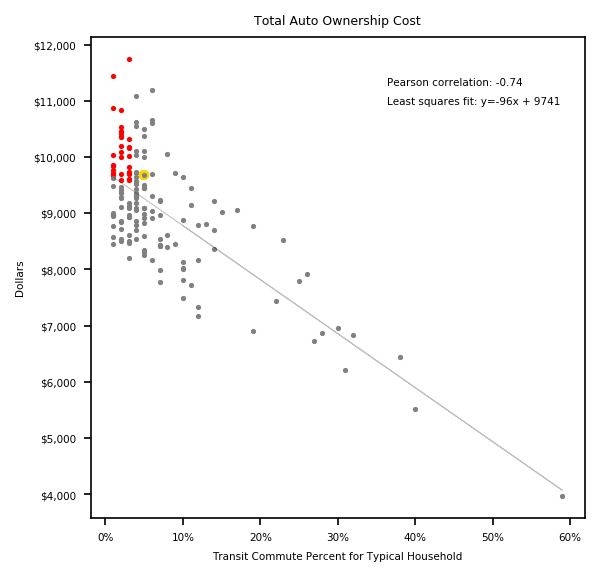

In [10]:
a, b = show_scatter(df, 'Total Auto Ownership Cost', y_col='auto_ownership_cost_ami')

In [11]:
# cities with low auto ownership costs
low_auto_cost = df[['name', 'auto_ownership_cost_ami', 'pct_transit_commuters_ami']]
low_auto_cost = low_auto_cost.sort_values(['auto_ownership_cost_ami'])
low_auto_cost.head(20)

,name,auto_ownership_cost_ami,pct_transit_commuters_ami
108,"""New York""",3966.0,59.0
104,"""Jersey City""",5512.0,40.0
84,"""Boston""",6208.0,31.0
43,"""San Francisco""",6441.0,38.0
105,"""Newark""",6735.0,27.0
52,"""Washington""",6837.0,32.0
126,"""Philadelphia""",6872.0,28.0
57,"""Miami""",6900.0,19.0
71,"""Chicago""",6951.0,30.0
127,"""Pittsburgh""",7169.0,12.0


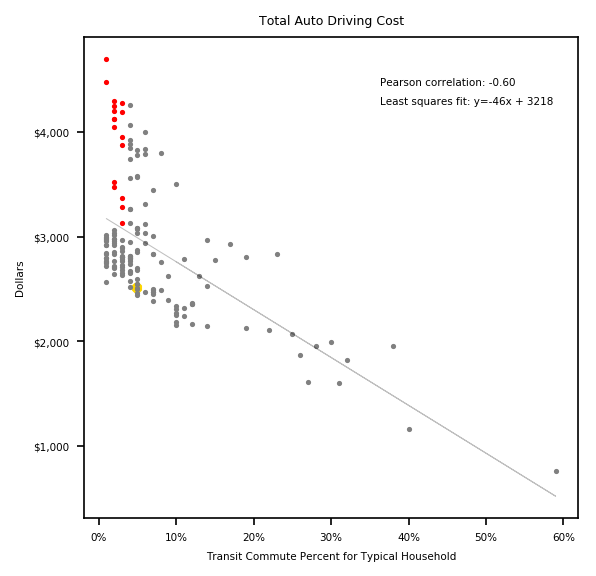

In [12]:
a, b = show_scatter(df, 'Total Auto Driving Cost', y_col='vmt_cost_ami')

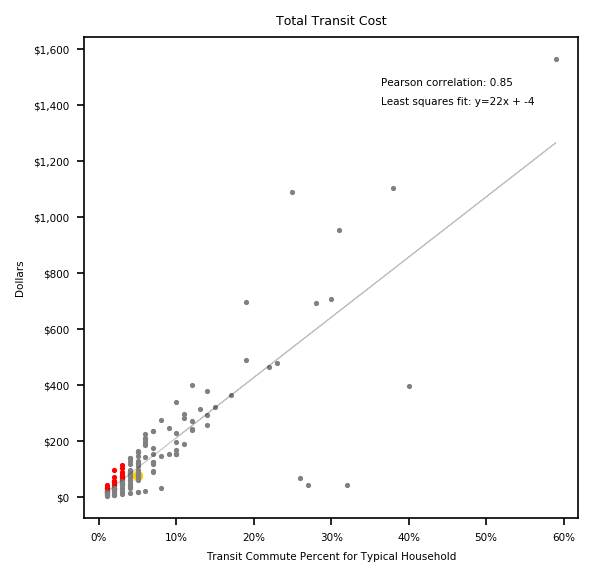

In [13]:
a, b = show_scatter(df, 'Total Transit Cost', y_col='transit_cost_ami')

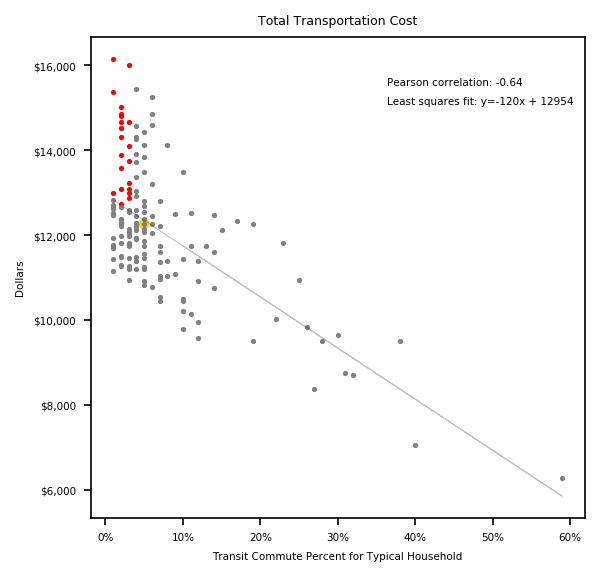

In [14]:
a, b = show_scatter(df)

In [15]:
# cities with low transportation costs
low_t_cost = df[['name', 't_cost_ami', 'pct_transit_commuters_ami']]
low_t_cost = low_t_cost.sort_values(['t_cost_ami'])
low_t_cost.head(20)

,name,t_cost_ami,pct_transit_commuters_ami
108,"""New York""",6298.0,59.0
104,"""Jersey City""",7075.0,40.0
105,"""Newark""",8389.0,27.0
52,"""Washington""",8700.0,32.0
84,"""Boston""",8761.0,31.0
43,"""San Francisco""",9501.0,38.0
57,"""Miami""",9514.0,19.0
126,"""Philadelphia""",9520.0,28.0
127,"""Pittsburgh""",9576.0,12.0
71,"""Chicago""",9649.0,30.0


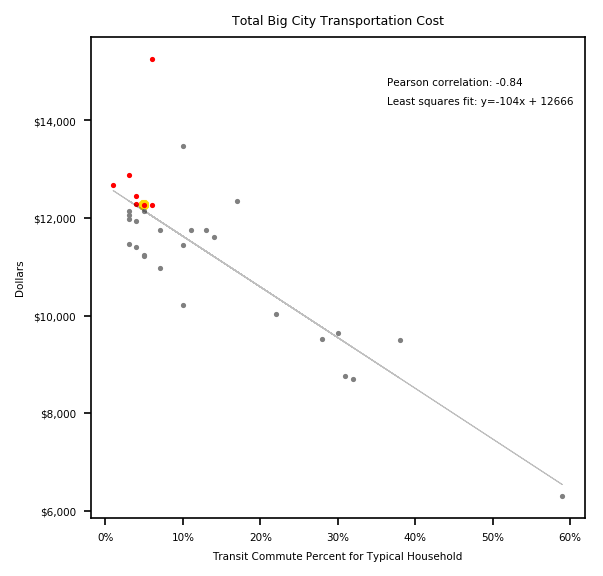

In [16]:
above_df, not_above = show_scatter(big_city_df, 'Total Big City Transportation Cost')

In [17]:
# big cities with above trendline costs and below median transit
above_df[['name', 't_cost_ami', 'pct_transit_commuters_ami']].sort_values(['t_cost_ami']).head(20)

,name,t_cost_ami,pct_transit_commuters_ami
136,"""Austin""",12264.0,5.0
98,"""Las Vegas""",12269.0,6.0
150,"""San Antonio""",12285.0,4.0
140,"""El Paso""",12452.0,4.0
122,"""Oklahoma City""",12671.0,1.0
141,"""Fort Worth""",12885.0,3.0
44,"""San Jose""",15265.0,6.0


In [18]:
# big cities ranked by lowest total transportation costs
bc_t_cost = big_city_df[['name', 't_cost_ami', 'pct_transit_commuters_ami']]
bc_t_cost = bc_t_cost.sort_values(['t_cost_ami'])
bc_t_cost.head(len(bc_t_cost))

,name,t_cost_ami,pct_transit_commuters_ami
108,"""New York""",6298.0,59.0
52,"""Washington""",8700.0,32.0
84,"""Boston""",8761.0,31.0
43,"""San Francisco""",9501.0,38.0
126,"""Philadelphia""",9520.0,28.0
71,"""Chicago""",9649.0,30.0
83,"""Baltimore""",10023.0,22.0
163,"""Milwaukee""",10219.0,10.0
87,"""Detroit""",10969.0,7.0
120,"""Columbus""",11218.0,5.0


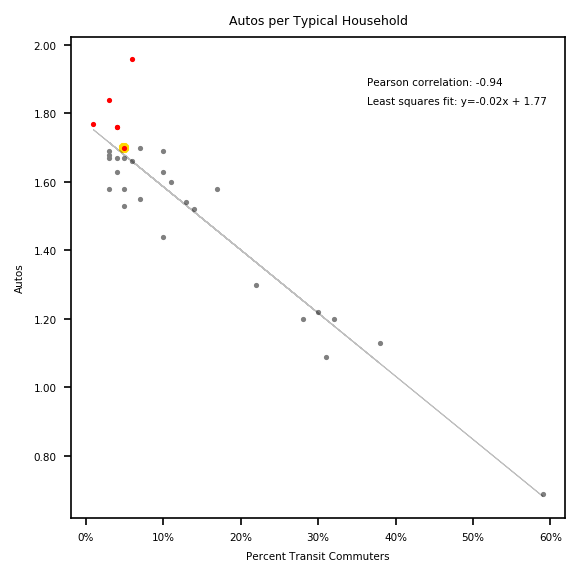

In [19]:
hh_auto_a, hh_auto_b = show_scatter(big_city_df, 'Autos per Typical Household', y_col='autos_per_hh_ami', xylabels=("Percent Transit Commuters", "Autos"), terse=False, y_dollars=False)

In [20]:
# big cities with high autos per household
hh_auto_a[['name', 'autos_per_hh_ami']]

,name,autos_per_hh_ami
44,"""San Jose""",1.96
122,"""Oklahoma City""",1.77
136,"""Austin""",1.70
140,"""El Paso""",1.76
141,"""Fort Worth""",1.84
150,"""San Antonio""",1.76


In [21]:
# bonus: a regression taking into consideration local housing costs
model = sm.OLS(df['t_cost_ami'], 
               sm.add_constant(df[['pct_transit_commuters_ami', 'median_gross_rent']]))
results = model.fit()
summary = results.summary()
print(summary.tables[0])
print(summary.tables[1])

                            OLS Regression Results                            
Dep. Variable:             t_cost_ami   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     283.0
Date:                Tue, 06 Oct 2020   Prob (F-statistic):           1.98e-53
Time:                        15:53:38   Log-Likelihood:                -1313.7
No. Observations:                 164   AIC:                             2633.
Df Residuals:                     161   BIC:                             2643.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 